In [7]:
%load_ext autoreload
%autoreload 2

# Ruggedness metric

Questions
1. What is the topological stability of a circuit?
2. What is the ruggedness of each circuit generated by the model?

In [1]:
from sklearn.manifold import TSNE
import itertools
from functools import partial
import json
import jax.numpy as jnp
import numpy as np
import os
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.evolution import calculate_ruggedness_from_perturbations
from evoscaper.utils.math import arrayise, make_batch_symmetrical_matrices
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.simulation import setup_model, make_rates, prep_sim, sim, prep_cfg


jax.config.update('jax_platform_name', 'gpu')


# jupyter nbconvert --to notebook --execute 07_ruggedness.ipynb --output=07_ruggedness_2.ipynb --ExecutePreprocessor.timeout=-1

In [ ]:
use_loaded = False
use_data = True
resimulate_analytics = True
analytic_key = 'Log sensitivity' 
top_write_dir = os.path.join('data', '07_ruggedness', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

dir_src = os.path.join('data', '01_cvae', '2025_02_23__18_41_24')
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
fn_saves = os.path.join(dir_src, 'saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4')

config = {'fn_saves': fn_saves}
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)

In [3]:
saves_loaded = load_json_as_dict(fn_saves)

(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = arrayise(saves_loaded[str(list(saves_loaded.keys())[-1])]['params'])



xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
config_bio_u = config_bio['base_configs_ensemble']['generate_species_templates']
config_bio_u.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
input_species = data[data['sample_name'].notna()]['sample_name'].unique()
config_bio = prep_cfg(config_bio_u, input_species)

config_sim = load_json_as_dict('configs/cvae_multi/simulation_settings.json')
config_bio.update(config_sim)

# Run verification

In [ ]:
if use_loaded:
    analytics = load_json_as_dict(
        'data/02_cvae_verify/2025_01_24__14_05_18/analytics.json')
    fake_circuits = np.load('data/02_cvae_verify/2025_01_24__14_05_18/fake_circuits.npy')
    ts = np.load('data/02_cvae_verify/2025_01_24__14_05_18/ts.npy')
    y0m = np.load('data/02_cvae_verify/2025_01_24__14_05_18/y0m.npy')
    ys = np.load('data/02_cvae_verify/2025_01_24__14_05_18/ys.npy')
    sampled_cond = np.load('data/02_cvae_verify/2025_01_24__14_05_18/sampled_cond.npy')
    
    fake_circuits = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)
    sampled_cond = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
    idxs_good = np.where(~np.isnan(sampled_cond.squeeze()) & ~np.isinf(sampled_cond.squeeze()))
elif use_data:
    filt = data['sample_name'].isin(config_dataset.output_species)
    fake_circuits = data[filt][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].to_numpy()
    analytics = {'sensitivity': np.array(data['sensitivity']).reshape(len(fake_circuits), len(data['sample_name'].unique())),
                 'precision': np.array(data['precision']).reshape(len(fake_circuits), len(data['sample_name'].unique()))}
    sampled_cond = np.log10(np.array(data[filt]['sensitivity'])[:, None])
    s = data[filt][config_dataset.objective_col[0]].to_numpy()
    s = np.where(np.abs(s) < np.inf, s, np.nan)
    sampled_cond = y_datanormaliser.create_chain_preprocessor(y_methods_preprocessing)(s, col=config_dataset.objective_col[0])[:, None]
    idxs_good = np.where(~np.isnan(s) & ~np.isinf(s))
    # fake_circuits = fake_circuits[idxs_good]
else:
    (
        analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond, adh
    ) = verify(params=params,
               rng=rng,
               decoder=decoder,
               df=df,
               cond=np.array([-0.1, 1.1]),
               config_bio=config_bio,
               config_norm_y=config_norm_y,
               config_dataset=config_dataset,
               config_model=config_model,
               x_datanormaliser=x_datanormaliser,
               x_methods_preprocessing=x_methods_preprocessing,
               y_datanormaliser=y_datanormaliser,
               output_species=config_dataset.output_species,
               signal_species=config_dataset.signal_species,
               input_species=data[data['sample_name'].notna()
                                  ]['sample_name'].unique(),
               n_to_sample=int(hpos['eval_n_to_sample']),
               visualise=False,
               top_write_dir=top_write_dir,
               return_relevant=True,
               impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                                   df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))
    idxs_good = np.where(~np.isnan(sampled_cond.squeeze()) & ~np.isinf(sampled_cond.squeeze()))
        
if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity'])
    analytics['Log precision'] = np.log10(analytics['precision'])
    

/tmp/ipykernel_478407/1174342006.py:18: RuntimeWarning: divide by zero encountered in log10
  sampled_cond = np.log10(np.array(data[filt]['sensitivity'])[:, None])


# Ruggedness functions

In [6]:
def calculate_ruggedness(interactions, eps_perc, analytic, input_species, config_dataset, config_bio,
                         analytics_original, resimulate_analytics: bool = False):

    n_samples = interactions.shape[0]
    n_interactions = interactions.shape[1]
    n_perturbs = n_interactions + resimulate_analytics
    eps = eps_perc * np.abs(interactions).max()
    perturbations = jax.vmap(
        partial(create_perturbations, eps=eps))(interactions)
    if resimulate_analytics:
        perturbations = np.concatenate([perturbations, interactions[:, None, :]], axis=1)

    analytics_perturbed, ys, ts, y0m, y00s, ts0 = simulate_perturbations(
        perturbations, config_dataset, config_bio, input_species)
    write_json(analytics_perturbed, os.path.join(top_write_dir, 'analytics.json'))
    
    analytic_perturbed = jnp.array(
        analytics_perturbed[analytic]).reshape(n_samples, n_perturbs, -1)
    if resimulate_analytics:
        analytic_perturbed = analytic_perturbed[:, :-1, :]
        analytic_og = analytic_perturbed[:, -1, :]
    else:
        analytic_og = np.array(analytics_original[analytic][:n_samples])
        
    # If loaded from previous data where not all analytics were saved
    if analytic_perturbed.shape[-1] != analytic_og.shape[-1]: 
        analytic_perturbed = analytic_perturbed[..., -analytic_og.shape[-1]:]

    ruggedness = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
        analytic_perturbed, analytic_og[:, None, :])

    return ruggedness, (analytics_perturbed, ys, ts, y0m, y00s, ts0)


def create_perturbations(interactions, eps):

    interactions_expanded = jnp.ones(
        (len(interactions), len(interactions))) * interactions

    perturbations = interactions_expanded + \
        jnp.eye(len(interactions_expanded), len(interactions_expanded)) * eps

    return perturbations


def simulate_perturbations(interactions, config_dataset, config_bio, input_species):

    interactions_reshaped = make_batch_symmetrical_matrices(
        interactions.reshape(-1, interactions.shape[-1]), side_length=len(input_species))

    model_brn, qreactions, ordered_species, postproc = setup_model(
        interactions_reshaped, config_bio, input_species, config_dataset.x_type)

    forward_rates, reverse_rates = make_rates(
        config_dataset.x_type, interactions_reshaped, postproc)

    (signal_onehot, signal_target, y00, t0, t1, dt0, dt1, stepsize_controller, total_time, threshold_steady_states, save_steps, max_steps, forward_rates, reverse_rates) = prep_sim(
        config_dataset.signal_species, qreactions, interactions_reshaped, config_bio, forward_rates, reverse_rates)

    #
    # threshold_steady_states = 0.01  # config_bio['simulation']['threshold_steady_states']
    # t1 = 1
    # total_time = 1
    #

    print('Starting sim')
    analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
                                            qreactions,
                                            signal_onehot, signal_target,
                                            t0, t1, dt0, dt1,
                                            save_steps, max_steps,
                                            stepsize_controller,
                                            threshold=threshold_steady_states,
                                            total_time=total_time)
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity'])
    analytics['Log precision'] = np.log10(analytics['precision'])

    return analytics, ys, ts, y0m, y00s, ts0


In [ ]:
eps_perc = - 1e-2
eps = eps_perc * np.abs(fake_circuits).max()
print('eps:', eps)

fake_circuits_half = fake_circuits[:int(len(fake_circuits)/2)]
ruggedness, _ = calculate_ruggedness(fake_circuits_half, eps_perc=eps_perc, analytic='Log sensitivity',
                                     input_species=input_species, config_dataset=config_dataset, config_bio=config_bio,
                                     analytics_original=analytics, resimulate_analytics=resimulate_analytics)

eps: -0.26120000839199997
Starting sim
Simulating steady states for 600 circuits
Done:  0:00:00.653523
Steady states found after 0 mins and 0 secs. Now calculating signal response
Done:  0:00:00.059179
Signal response found after 0 mins and 0 secs.


In [133]:
np.save(os.path.join(top_write_dir, 'ruggedness.npy'), ruggedness)
for i, l in zip(_[1:], ['ys.npy', 'ts.npy', 'y0m.npy', 'y00s.npy', 'ts0.npy']):
    np.save(os.path.join(top_write_dir, l), i) 
write_json(_[0], os.path.join(top_write_dir, 'analytics.json'))
# json.dump(_[0], open(os.path.join(top_write_dir, 'analytics.json'), 'w'))
print(top_write_dir)

data/07_ruggedness/2025_02_07__14_46_28


# Visualise

In [ ]:
dir_load = os.path.join('data', '07_ruggedness', '2025_01_27__22_09_38')  # Used dataset from '01_cvae/2025_01_23__15_38_01' and old analytics
dir_load = os.path.join('data', '07_ruggedness', '2025_02_07__14_46_28')  # Resimulated '01_cvae/2025_01_23__15_38_01'
dir_load = os.path.join('data', '07_ruggedness', '2025_03_05__00_08_44')  # Data 1/2 from '01_cvae/2025_02_23__18_41_24' ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json')

fake_circuits_f = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)
n_samples = fake_circuits_f.shape[0]
n_interactions = fake_circuits_f.shape[-1]
n_perturbs = n_interactions + resimulate_analytics

analytics_perturbed = load_json_as_dict(os.path.join(
    dir_load, 'analytics.json'))
analytic_og = np.array(analytics['Log sensitivity'])
analytic_perturbed = np.array(analytics_perturbed['Log sensitivity'])
analytic_perturbed = analytic_perturbed.reshape(n_samples, n_perturbs, -1)[idxs_good]
analytic_og = analytic_og[idxs_good]
if use_data:
    analytic_perturbed = analytic_perturbed[..., -analytic_og.shape[-1]:]
if resimulate_analytics:
    analytic_perturbed = analytic_perturbed[:, :-1, :]
    analytic_og = analytic_perturbed[:, -1, :]

ruggedness_loaded = np.load(os.path.join(
    dir_load, 'ruggedness.npy'))[idxs_good]
# ruggedness_loaded = np.where(
#     np.abs(ruggedness_loaded) < np.inf, ruggedness_loaded, np.nan)
# ruggedness_loaded = ruggedness_loaded / analytic_og
ruggedness_log = np.where(
    np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)

eps_perc = 1e-3
eps = eps_perc * np.abs(fake_circuits_f).max()
diffs = analytic_perturbed - analytic_og[:, None, :]
dp = diffs / (eps * analytic_og[:, None, :])
# dp = (analytic_perturbed - analytic_og[:, None, :]) / eps
# dp = diffs / (eps * np.array(analytics_perturbed['initial_steady_states'])[idxs_good][:, None, -3:])
rug_dp = np.log10(np.sqrt(np.nansum(dp**2, axis=1)))
rug_dp = np.where(rug_dp != -np.inf, rug_dp, np.nanmin(np.log10(rug_dp)))

ValueError: cannot reshape array of size 27087795 into shape (859930,6,newaxis)

In [19]:
analytic_perturbed.shape[0] / n_samples

3.5

Percentage of circuits with no change: 0.15377407407407406


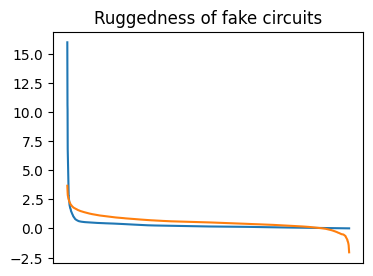

In [ ]:
output_idx = -1
plt.figure(figsize=(4, 3))
sns.lineplot(x=np.arange(ruggedness_loaded.shape[0]), y=np.sort(
    ruggedness_loaded[:, output_idx])[::-1])
sns.lineplot(x=np.arange(rug_dp.shape[0]), y=np.sort(
    rug_dp[:, output_idx])[::-1])
# plt.yscale('log')
plt.title('Ruggedness of fake circuits')
plt.xticks([])

print('Percentage of circuits with no change:', np.sum(
    dp * eps == 0) / np.prod(analytic_perturbed.shape))

/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Text(0.5, 1.0, 'Mean and STD of dp: RNA_2')

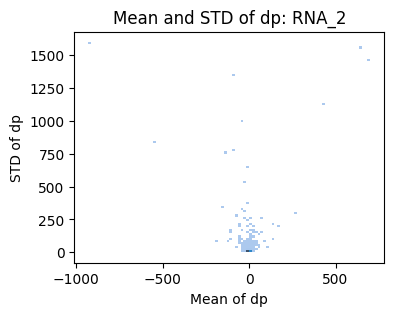

In [ ]:
dp_mean = dp.mean(axis=1)
dp_std = dp.std(axis=1)

d1 = pd.DataFrame(
    data={'Mean of dp': dp_mean[:, -2], 'STD of dp': dp_std[:, -2]})
d2 = pd.DataFrame(
    data={'Mean of dp': dp_mean[:, -1], 'STD of dp': dp_std[:, -1]})
d1['Species'] = 'RNA_1'
d2['Species'] = 'RNA_2'
d = pd.concat([d1, d2]).reset_index(drop=True)
# sns.histplot(d, x='Mean of dp', y='STD of dp', hue='Species', bins=100, element='step')
plt.figure(figsize=(4, 3))
sns.histplot(d[d['Species'] == 'RNA_2'], x='Mean of dp',
             y='STD of dp', bins=100, element='step')
# sns.kdeplot(d[d['Species'] == 'RNA_1'], x='Mean of dp', y='STD of dp', bins=100, element='step', alpha=0.7)
plt.title('Mean and STD of dp: RNA_2')

In [ ]:
diffs_sub = diffs[..., -2:]
label_species = np.ones_like(diffs_sub, dtype=object)
label_interactions = np.ones_like(diffs_sub, dtype=object)
for i in range(diffs_sub.shape[-1]):
    label_species[..., i] = f'RNA_{i+1}'

for ii, (i, j) in enumerate(sorted(set([tuple(np.sort([i, j]).tolist()) for i, j in itertools.product(np.arange(3), np.arange(3))]))):
    label_interactions[:, ii] = f'RNA_{i}-RNA_{j}'

Text(0.5, 1.0, 'Change in log sensitivity for each interaction')

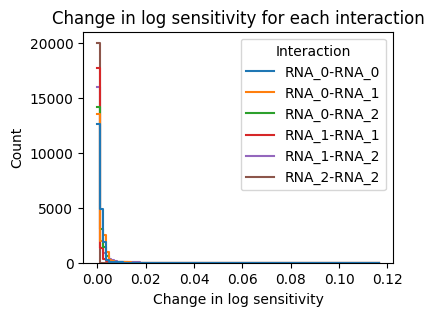

In [ ]:
df = pd.DataFrame(data={'Change in log sensitivity': np.abs(diffs_sub).flatten() * eps, 
                        'Species': label_species.flatten(),
                        'Interaction': label_interactions.flatten()})
plt.figure(figsize=(4, 3))
sns.histplot(df, x='Change in log sensitivity', hue='Interaction', bins=100, element='step', fill=False)
plt.title('Change in log sensitivity for each interaction')


In [ ]:
# Starting point vs. dp

# fig, axes = plt.subplots(1, n_interactions, figsize=(6*n_interactions, 4))
# for i in range(n_interactions):
# # analytic_perturbed.reshape(n_interactions, len(analytic_og), -1)
#     # sns.histplot(x=dp[i, :, output_idx] * eps, y=analytic_og[:, output_idx], bins=50, element='step', ax=axes[i])
#     sns.histplot(x=analytic_perturbed.reshape(n_interactions, len(analytic_og), -1)[i, :, output_idx], 
#                  y=analytic_og[:, output_idx], bins=50, element='step', ax=axes[i])
#     axes[i].set_title(np.unique(label_interactions)[i])
#     axes[i].set_xlabel('Perturbed log sensitivity')
#     axes[i].set_ylabel('Starting log sensitivity')
fig, axes = plt.subplots(2, n_interactions, figsize=(3*n_interactions, 3*2))
for i in range(n_interactions):
    # analytic_perturbed.reshape(n_interactions, len(analytic_og), -1)
    # sns.histplot(x=dp[i, :, output_idx] * eps, y=analytic_og[:, output_idx], bins=50, element='step', ax=axes[0, i])
    sns.histplot(x=analytic_og[:, output_idx], 
                 y=analytic_perturbed.reshape(n_samples, n_interactions, -1)[:, i, output_idx], 
                 bins=50, element='step', ax=axes[0, i])
    axes[0, i].set_title(np.unique(label_interactions)[i])
    axes[0, i].set_xlabel('Starting log sensitivity')
    axes[0, i].set_ylabel('Perturbed log sensitivity')
for i in range(n_interactions):
    sns.histplot(x=fake_circuits_f[:, i], 
                 y=analytic_perturbed.reshape(n_samples, n_interactions, -1)[:, i, output_idx], 
                 bins=50, element='step', ax=axes[1, i])
    axes[1, i].set_title(np.unique(label_interactions)[i])
    axes[1, i].set_xlabel('Initial interaction energy (kcal/mol)')
    axes[1, i].set_ylabel('Perturbed log sensitivity')
plt.suptitle('Log sensitivity of RNA_2 after perturbing interactions')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir,
            f"2d_histplot_all.png"), dpi=300)
plt.close()

In [ ]:
# Starting strong: what's the change?

fig, axes = plt.subplots(2, n_interactions, figsize=(3*n_interactions, 3*2))
idxs_strong = np.where(analytic_og[:, output_idx] > 0)
for i in range(n_interactions):
# analytic_perturbed.reshape(n_interactions, n_samples, -1)
    # sns.histplot(x=dp[i, :, output_idx] * eps, y=analytic_og[:, output_idx], bins=50, element='step', ax=axes[0, i])
    sns.histplot(x=analytic_og[:, output_idx][idxs_strong], 
                 y=analytic_perturbed.reshape(n_samples, n_interactions, -1)[:, i, output_idx][idxs_strong], 
                 bins=50, element='step', ax=axes[0, i])
    axes[0, i].set_title(np.unique(label_interactions)[i])
    axes[0, i].set_xlabel('Starting log sensitivity')
    axes[0, i].set_ylabel('Perturbed log sensitivity')
for i in range(n_interactions):
    sns.histplot(x=fake_circuits_f[:, i][idxs_strong], 
                 y=diffs[:, i, output_idx][idxs_strong], 
                 bins=50, element='step', ax=axes[1, i])
    axes[1, i].set_title(np.unique(label_interactions)[i])
    axes[1, i].set_xlabel('Initial interaction energy (kcal/mol)')
    axes[1, i].set_ylabel('Change in log sensitivity')
plt.suptitle(f'Log sensitivity of $RNA_2$ in strong circuits ($s_0$ > 0) after perturbing interactions')
# plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir,
            f"2d_histplot_high_sens.png"), dpi=300)
plt.close()

In [ ]:
ruggedness_log.min(), ruggedness_log.max()

(np.float32(-7.0640373), np.float32(1.4157578))

In [ ]:
# sampled_cond_rev = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond[..., 0], col=config_dataset.objective_col[0])
sampled_cond_rev = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)])


In [ ]:
plot_energy_spaces = True
plot_all = True

if plot_energy_spaces:

    def plot_energy_spaces(energies, hue):
        # idxs = np.array([[(i, j) for j in range(energies.shape[-1])]
        #                 for i in range(energies.shape[-1])])
        idxs_triu = [tuple(np.sort([i, j]).tolist()) for i, j in zip(*np.triu_indices(n_interactions))]

        nrows = energies.shape[-1]
        ncols = energies.shape[-1]
        fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20),
                                sharex=True, sharey=True)
        for i, j in idxs_triu:
            is_last = (i, j) == idxs_triu[-1]
            if i != j or is_last:
                sns.scatterplot(x=energies[..., i], y=energies[..., j], 
                                hue=hue, palette='viridis', ax=axs[i, j],
                                alpha=0.1,
                                legend=True if is_last else False)
            axs[i, j].set_title(f"{i} vs. {j}")
            # axs[i, j].set_xlabel(str(i))
            # axs[i, j].set_ylabel(str(j))
        # for i in range(nrows):
        #     for j in range(ncols):
                
        #         is_last = (np.sum([i, j] != idxs[-1, -1]) == 0)
        #         if i != j or is_last:
        #             sns.scatterplot(x=energies[..., idxs[i, j][0]], y=energies[..., idxs[i, j][1]], 
        #                             hue=hue, palette='viridis', ax=axs[i, j],
        #                             alpha=0.1,
        #                             legend=True if is_last else False)
        #         axs[i, j].set_title(f"{idxs[i, j][0]} vs. {idxs[i, j][1]}")
        #         # axs[i, j].set_xlabel(str(idxs[i, j][0]))
        #         # axs[i, j].set_ylabel(str(idxs[i, j][1]))

    plot_energy_spaces(fake_circuits_f, ruggedness_log[..., output_idx])
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir,
                f"energy_space_ruggedness.png"), dpi=300)
    plt.close()
    
    plot_filt = ruggedness_log[..., output_idx] > -3
    plot_energy_spaces(fake_circuits_f[plot_filt], ruggedness_log[..., output_idx][plot_filt])
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir,
                f"energy_space_ruggedness_gt-3.png"), dpi=300)
    plt.close()
    
    plot_energy_spaces(fake_circuits_f, sampled_cond_rev[:, output_idx])
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir,
                f"energy_space_objective.png"), dpi=300)
    plt.close()
    
    if plot_all:
        plot_filt = sampled_cond_rev[:, output_idx] > 0
        plot_energy_spaces(fake_circuits_f[plot_filt], sampled_cond_rev[:, output_idx][plot_filt])
        plt.tight_layout()
        plt.savefig(os.path.join(top_write_dir,
                    f"energy_space_objective_gt0.png"), dpi=300)
        plt.close()
        
        plot_filt = (sampled_cond_rev[:, output_idx] > -10) & (sampled_cond_rev[:, output_idx] < 3)
        plot_energy_spaces(fake_circuits_f[plot_filt], sampled_cond_rev[:, output_idx][plot_filt])
        plt.tight_layout()
        plt.savefig(os.path.join(top_write_dir,
                    f"energy_space_objective_lt3.png"), dpi=300)
        plt.close()
        
        plot_filt = (sampled_cond[:, output_idx] > -9) & (sampled_cond[:, output_idx] < 3)
        argsort_idxs = np.argsort(sampled_cond_rev[:, output_idx][plot_filt])
        plot_energy_spaces(fake_circuits_f[plot_filt][argsort_idxs], sampled_cond_rev[:, output_idx][plot_filt][argsort_idxs])
        plt.tight_layout()
        plt.savefig(os.path.join(top_write_dir,
                    f"energy_space_objective_lt3_sort.png"), dpi=300)
        plt.close()

# Visualise TSNE

In [ ]:
use_loaded_tsne2 = False


h_all = encoder(params, rng, np.concatenate([fake_circuits, sampled_cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

random_state = 0
perplexity = 30
tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, max_iter=1000)
if use_loaded_tsne2:
    tsne_result_2 = np.load('data/07_ruggedness/2025_01_28__18_13_48/tsne_result_2.npy')
else:
    tsne_result_2 = tsne.fit_transform(h_all)
    np.save(os.path.join(top_write_dir, 'tsne_result_2.npy'), tsne_result_2)
    

In [ ]:
def plot_all_dp(res, s_thresh = -np.inf):
    fig, axes = plt.subplots(
        1, 3 + n_interactions, figsize=(6*(2+n_interactions), 5))
    sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=sampled_cond_rev.reshape(np.prod(sampled_cond_rev.shape[:-1]), -1)[..., 0],
                    palette='viridis', ax=axes[0], alpha=0.1)
    axes[0].set_title('Objective')
    s = analytics['Log sensitivity'][idxs_good][..., output_idx]
    idxs_noinf = np.where((np.abs(s) < np.inf) & (s > s_thresh))
    sns.scatterplot(x=res[:, 0][idxs_noinf], y=res[:, 1][idxs_noinf], hue=s[idxs_noinf],
                    palette='viridis', ax=axes[1], alpha=0.1)
    axes[1].set_title('Actual')
    sns.scatterplot(x=res[:, 0][idxs_noinf], y=res[:, 1][idxs_noinf], hue=ruggedness_log[..., output_idx][idxs_noinf],
                    palette='viridis', ax=axes[2], alpha=0.3)
    axes[2].set_title('Ruggedness')
    for i in range(n_interactions):
        dp_i = dp[:, i, output_idx]
        idxs_nonan = np.where(~np.isnan(dp_i) & ~np.isinf(dp_i) & (s > s_thresh))
        sns.scatterplot(x=res[:, 0][idxs_nonan], y=res[:, 1][idxs_nonan], hue=dp_i[idxs_nonan] * eps,
                        palette='viridis', ax=axes[3+i], alpha=0.2)
        axes[3+i].set_title('dp of interaction ' + np.unique(label_interactions)[i])
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
        

plot_all_dp(tsne_result_2)
plt.suptitle(f'TSNE perplexity={perplexity}')
plt.savefig(os.path.join(top_write_dir, 'tsne.png'))
plt.close()

In [ ]:
def plot_all_dp(res, s_thresh = -np.inf):
    fig, axes = plt.subplots(
        1, 3 + n_interactions, figsize=(6*(2+n_interactions), 5))
    sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=sampled_cond_rev.reshape(np.prod(sampled_cond_rev.shape[:-1]), -1)[..., 0],
                    palette='viridis', ax=axes[0], alpha=0.1)
    axes[0].set_title('Objective')
    s = analytics['Log sensitivity'][idxs_good][..., output_idx]
    idxs_noinf = np.where((np.abs(s) < np.inf) & (s > s_thresh))
    sns.scatterplot(x=res[:, 0][idxs_noinf], y=res[:, 1][idxs_noinf], hue=s[idxs_noinf],
                    palette='viridis', ax=axes[1], alpha=0.1)
    axes[1].set_title('Actual')
    sns.scatterplot(x=res[:, 0][idxs_noinf], y=res[:, 1][idxs_noinf], hue=ruggedness_log[..., output_idx][idxs_noinf],
                    palette='viridis', ax=axes[2], alpha=0.3)
    axes[2].set_title('Ruggedness')
    for i in range(n_interactions):
        dp_i = dp[:, i, output_idx]
        idxs_nonan = np.where(~np.isnan(dp_i) & ~np.isinf(dp_i) & (s > s_thresh))
        sns.scatterplot(x=res[:, 0][idxs_nonan], y=res[:, 1][idxs_nonan], hue=dp_i[idxs_nonan] * eps,
                        palette='viridis', ax=axes[3+i], alpha=0.2)
        axes[3+i].set_title('dp of interaction ' + np.unique(label_interactions)[i])
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

plot_all_dp(tsne_result_2, s_thresh=-2)
plt.suptitle(f'TSNE perplexity={perplexity}')
plt.savefig(os.path.join(top_write_dir, 'tsne_high_sens.png'))
plt.close()

In [ ]:
def plot_all(res):
    fig, axes = plt.subplots(
        1, 3 + n_interactions, figsize=(6*(2+n_interactions), 6))
    sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=sampled_cond_rev.reshape(np.prod(sampled_cond_rev.shape[:-1]), -1)[..., 0],
                    palette='viridis', ax=axes[0], alpha=0.1)
    axes[0].set_title('Objective')
    s = analytics['Log sensitivity'][idxs_good][..., output_idx]
    idxs_noinf = np.where(~np.isinf(s))
    sns.scatterplot(x=res[:, 0][idxs_noinf], y=res[:, 1][idxs_noinf], hue=s[idxs_noinf],
                    palette='viridis', ax=axes[1], alpha=0.1)
    axes[1].set_title('Actual')
    sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=ruggedness_log[..., output_idx],
                    palette='viridis', ax=axes[2], alpha=0.3)
    axes[2].set_title('Ruggedness')
    for i in range(n_interactions):
        sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=fake_circuits_f[:, i],
                        palette='viridis', ax=axes[3+i], alpha=0.2)
        axes[3+i].set_title('Binding energy of ' + np.unique(label_interactions)[i])
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
        

plot_all(tsne_result_2)
plt.suptitle(f'TSNE perplexity={perplexity}')
plt.savefig(os.path.join(top_write_dir, 'tsne_2.png'))
plt.close()
        

# Visualise PCA

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(h_all)

# # Plot the PCA result
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cond_rev.reshape(np.prod(cond_rev.shape[:-1]), -1)[..., 0], palette='viridis', alpha=0.3)
# plt.title('PCA of h_all with 2 components')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.show()

In [ ]:
plot_all(pca_result)
plt.suptitle(f'PCA components=2')
plt.savefig(os.path.join(top_write_dir, 'pca.png'))
plt.close()

# Visualise UMAP

In [ ]:
import umap

# Perform UMAP
umap_model = umap.UMAP(n_components=2, random_state=random_state)
umap_result = umap_model.fit_transform(h_all)

2025-01-29 13:09:44.005050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738156184.045575 2267282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738156184.058274 2267282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
plot_all(umap_result)
plt.suptitle(f'UMAP components=2')
plt.savefig(os.path.join(top_write_dir, 'umap.png'))
plt.close()

# Visualise z

In [ ]:
# n_categories = len(fake_circuits)
# n_objectives = len(config_dataset.objective_col)
# n_to_sample = fake_circuits.shape[1]
# hidden_size = h_all.shape[-1]
# z = jax.random.normal(rng, (n_categories ** n_objectives, n_to_sample, hidden_size))
# z = np.concatenate([z, sampled_cond], axis=-1)
# z = z.reshape(np.prod(z.shape[:-1]), -1)


In [ ]:
# random_state = 0
# perplexity = 30
# tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, max_iter=1000)
# tsne_z = tsne.fit_transform(z)

In [ ]:
# fig, axes = plt.subplots(
#     1, 2 + fake_circuits_f.shape[-1], figsize=(6*(2+fake_circuits_f.shape[-1]), 5))
# for j in range(fake_circuits_f.shape[-1]):
#     for i in range(z.shape[-1] - 1):
#         sns.scatterplot(x=z[..., i], y=fake_circuits_f[..., j], hue=analytics['Log sensitivity'][..., output_idx],
#                         palette='viridis', ax=axes[j], alpha=0.1, legend=False)

In [ ]:
# nrow = int(np.sqrt(z.shape[-1] -1))
# ncol = int(np.sqrt(z.shape[-1] -1))
# fig, axes = plt.subplots(
#     nrow, ncol, figsize=(6*ncol, 5*nrow))
# for i in range(z.shape[-1] -1):
#     sns.scatterplot(x=z[..., i], y=analytics['Log sensitivity'][..., output_idx], hue=ruggedness_log[..., output_idx],
#                     palette='viridis', ax=axes.flatten()[i], alpha=0.1, legend=False)

In [ ]:
# import itertools
# idxs_plot = sorted(set([tuple(np.sort([i, j]).tolist()) for i, j in itertools.product(np.arange(fake_circuits_f.shape[-1]), np.arange(fake_circuits_f.shape[-1])) if i != j]))
# len(idxs_plot)

15

In [ ]:
# plt.figure(figsize=(20, 20))
# for i in range(fake_circuits_f.shape[-1]):
#     for j in range(fake_circuits_f.shape[-1]):
#         is_final = (i == fake_circuits_f.shape[-1] - 1) & (j == fake_circuits_f.shape[-1] - 1)
#         if i != j or is_final:
#             plt.subplot(fake_circuits_f.shape[-1], fake_circuits_f.shape[-1], i * fake_circuits_f.shape[-1] + j + 1)
#             sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=ruggedness_log[:, output_idx], palette='viridis', alpha=0.2, legend=True if is_final else False)
#             # sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=None, palette='viridis', alpha=0.2, legend=True if is_final else False)